In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import json
import re
from pathlib import Path
from mimas.helper.fileio import NumpyEncoder

import seaborn as sns
from matplotlib import rcParams
matplotlib_font_size = 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = matplotlib_font_size
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['svg.fonttype'] = 'none'

path_data = Path().cwd().parent / 'data'

path_figures = Path().cwd().parent / 'figures'
path_figures.mkdir(parents=True, exist_ok=True)

In [6]:
path_benchmark_data = path_data/"public_repository"/"whole_repository"

all_df = []
for file_benchmark in path_benchmark_data.glob("*.csv"):
    df = pd.read_csv(file_benchmark)
    df["filename"] = file_benchmark.stem
    all_df.append(df)

df = pd.concat(all_df)
df["charge"]=df["filename"].str.extract("-charge_(.)-")
df

,idx,target,time_open,time_neutral_loss,number_of_spectra,filename,time_identity,charge
0,0,gpu,0.210223,0.221392,237185147,benchmark-open-charge_N-number_100-target_gpu,NaN,N
1,1,gpu,0.183666,0.187856,237185147,benchmark-open-charge_N-number_100-target_gpu,NaN,N
2,2,gpu,0.178730,0.178411,237185147,benchmark-open-charge_N-number_100-target_gpu,NaN,N
3,3,gpu,0.357621,0.305886,237185147,benchmark-open-charge_N-number_100-target_gpu,NaN,N
4,4,gpu,0.198936,0.193025,237185147,benchmark-open-charge_N-number_100-target_gpu,NaN,N
...,...,...,...,...,...,...,...,...
95,95,cpu,NaN,NaN,90658,benchmark-identity-charge_N-number_100-target_cpu,0.004555,N
96,96,cpu,NaN,NaN,60480,benchmark-identity-charge_N-number_100-target_cpu,0.003717,N
97,97,cpu,NaN,NaN,40307,benchmark-identity-charge_N-number_100-target_cpu,0.001981,N
98,98,cpu,NaN,NaN,73463,benchmark-identity-charge_N-number_100-target_cpu,0.006034,N


In [7]:
# Melting the dataframe
df_time = df.drop(columns=["number_of_spectra", "filename"])
df_melt = df_time.melt(id_vars=["idx", "target", "charge"], var_name="type", value_name="time")

df_melt


,idx,target,charge,type,time
0,0,gpu,N,time_open,0.210223
1,1,gpu,N,time_open,0.183666
2,2,gpu,N,time_open,0.178730
3,3,gpu,N,time_open,0.357621
4,4,gpu,N,time_open,0.198936
...,...,...,...,...,...
2395,95,cpu,N,time_identity,0.004555
2396,96,cpu,N,time_identity,0.003717
2397,97,cpu,N,time_identity,0.001981
2398,98,cpu,N,time_identity,0.006034


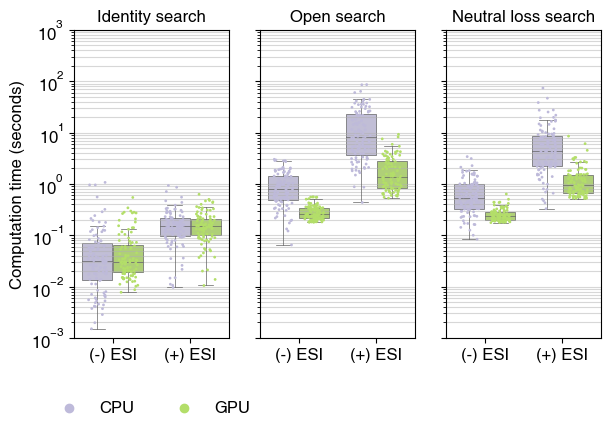

In [8]:
df_plot = df_melt
# color_palette = sns.color_palette("Set2", 2)
# color_palette = {'cpu': color_palette[0], 'gpu': color_palette[1]}
color_palette = sns.color_palette("Set3", 10)
color_palette={'cpu': color_palette[2],'gpu': color_palette[6],}
# color_palette = sns.color_palette("Set2", 6)
# color_palette = {'cpu': "#edc9bf", 'gpu': "#88cdcb"}
hue_order=["cpu", "gpu"]
order=["N", "P"]
ouput_order=["time_identity", "time_open", "time_neutral_loss"]

fig, axes = plt.subplots(nrows=1, ncols=len(ouput_order), figsize=(6.8, 4), sharex=False, sharey=True)

for i, search in enumerate(ouput_order):
    df_plot_cur=df_plot[df_plot["type"]==search]
    # Check methods
    ax = axes[i]
    ax.grid(True, which="both", axis="y", ls="-", alpha=0.5)
    ax.set_title({
        "time_identity": "Identity search",
        "time_open": "Open search",
        "time_neutral_loss": "Neutral loss search",
    }[search], fontsize=matplotlib_font_size)

    sns.boxplot(data=df_plot_cur, x="charge", y="time", hue="target", palette=color_palette, hue_order=hue_order, ax=ax, order=order,
                linewidth=0.5, fliersize=0)
    sns.stripplot(x="charge", y="time", hue="target", data=df_plot_cur, palette=color_palette, hue_order=hue_order, ax=ax, order=order,
                dodge=True, jitter=0.25, size=2, alpha=1, linewidth=0)

    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1000)
    ax.set_xlabel("")
    if i==0:
        ax.set_ylabel("Computation time (seconds)")
        # Move legend to bottom
        handles, labels = ax.get_legend_handles_labels()
        legend_dict = {l: h for h, l in zip(handles, labels)}
        labels_new = ["CPU", "GPU"]
        handles_new = [legend_dict[l] for l in ["cpu", "gpu"]]
        ax.legend(handles_new, labels_new, frameon=False, ncol=2, loc="lower center", bbox_to_anchor=(0.5, -0.3), fontsize=matplotlib_font_size)
    else:
        ax.set_ylabel("")
        ax.legend().remove()
    ax.set_xticklabels([{'N': "(-) ESI", 'P': "(+) ESI"}[x.get_text()] for x in ax.get_xticklabels()])

plt.savefig(path_figures / f"40_search_whole_repository-all.svg", bbox_inches='tight', dpi=1200)